In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import datetime as dt

#Useful packages for building deep neural networks. 
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Flatten,Dense,Dropout, Reshape,MaxPooling2D,Conv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

#Additional library which we will use for preprocessing our image data before training our model and to provide some specific evaluation metrics.
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

In [ ]:
#-------- KMEANS FEATURIZATION ----------

In [ ]:
# ----------------------------- K-Means Featurization (Feature engineering for machine learning - Zheng & Casari)
from sklearn.cluster import KMeans

class KMeansFeaturizer:
  def __init__(self, k = 100, target_scale = 5.0, random_state = None):
    self.k = k
    self.target_scale = target_scale
    self.random_state = random_state

  def fit(self, X, y = None):
    if y is None:
      km_model = KMeans(n_clusters=self.k,
                        n_init = 20,
                        random_state = self.random_state)
      km_model.fit(X)
      
      self.km_model_ = km_model
      self.cluster_centers_ = km_model.cluster_centers_
      return self

    data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))
    km_model_pretrain = KMeans(n_clusters=self.k,
                               n_init=20,
                               random_state=self.random_state)
    
    km_model_pretrain.fit(data_with_target)
    km_model = KMeans(n_clusters=self.k,
                      init=km_model_pretrain.cluster_centers_[:,:38],
                      n_init=1,
                      max_iter=1)
    
    km_model.fit(X)

    self.km_model = km_model
    self.cluster_centers_ = km_model.cluster_centers_
    return self

  def transform(self, X, y=None):
      clusters = self.km_model.predict(X)
      return clusters[:,np.newaxis]
      
  def fit_transform(self, X, y=None):
      self.fit(X, y)
      return self.transform(X, y)



In [ ]:
#LOAD DATA
data = pd.read_pickle('/content/drive/MyDrive/AA_assignments/Assignment 1/train_data_minmax_df3')
X = data.drop(columns = ['client_id', 'target'])
y = data['target']
data_with_target = data.drop(columns = ['client_id'])

In [ ]:
kmf = KMeansFeaturizer(k = 4, target_scale = 10).fit(X, y)

In [ ]:
kmf.transform(X) # Closest cluster ID for each input data point, add this as a feature

In [ ]:
# AUTOMATED FEATURE SELECTION - Recursive feature elimination and correlation-based elimination. SOURCE: https://towardsdatascience.com/designing-a-feature-selection-pipeline-in-python-859fec4d1b12

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from boruta import BorutaPy

class FeatureSelector:
    """
    The FeatureSelector class implement the following feature selection 
    methods:
        
    
    1. A method that removes features with very similar values. For example,
    a feature that contains 0 for every instance.
    
    2. A filter method that removes correlated features based on Pearson or
    Spearman's coefficient.
    
    3. A recursive feature elimination algorithm with cross validation.
    
    4. The Boruta method which uncovers features that are relevant to
    the outcome.
    
    
    Parameters
    ----------
    
    None
        
    Example
    -------
    
    # Define steps
    step1 = {'Constant Features': {'frac_constant_values': 0.90}}
    
    step2 = {'Correlated Features': {'correlation_threshold': 0.95}}
    
    step3 = {'Relevant Features': {'estimator': estimator,
                                   'cv': 5,
                                    'n_estimators': 1000,
                                    'max_iter': 100,
                                    'verbose': 50,
                                    'random_state': 42}}
    
    step4 = {'RFECV Features': {'estimator': estimator,
                                'cv': 2,
                                'step': 1,
                                'scoring': 'accuracy',
                                'verbose': 50,}}
    
    # Place steps in a list in the order you want them execute it
    steps = [step1, step2, step3, step4]
    
    # Initialize FeatureSelector()
    fs = FeatureSelector()
    
    # Apply feature selection methods
    X_selected = fs.fit(X_all_train, y_all_train, steps)
    
    
    Attributes
    ----------
    
    
    Author Information
    ------------------
    Frank Ceballos
    LinkedIn: <https://www.linkedin.com/in/frank-ceballos/>
    Date: January 31, 2020
    """
    
    
    def __init__(self):
        self.rfecv = None
        self.selected_features = None
    
    
    def fit(self, X, y, steps = {}):
        """
        Calls the feature selection methods in the order specified in steps and
        determines the selected features. 
        
        
        Parameters
        ----------
        X : pandas dataframe
            A data set where each row is an observation and each column a feature.
        
        y: numpy array
            A numpy array containing the targets
            
        steps: list
            The list of steps that determines the order to apply the
            feature selection algorithms. Each element in this list is a dict,
            where key can be:
                            'Constant Features', 
                            'Correlated Features'
                            'Relevant Features'
                            'RFECV Features'
            and the value is a dict with the parameters used to execute 
            the feature selection method.
            
            
        Returns
        -------
        None
        """
        
        # Determine if there are any methods that are not defined
        for step in steps:
            available_methods = ['Constant Features', 'Correlated Features', 'Relevant Features', 'RFECV Features']
            
            for key, value in step.items():
                if key not in available_methods:
                    print(f'{key} is not a valid key!')
                    print(f'Only these are available: {available_methods}')
                    print(f'Redefine the key in this dict/step: {step}')
                    print('Now exiting function!')
                    return None
        
        # Get the order the methods are going to be applied
        method_order = [[*step][0] for step in steps]
        
        # Get methods
        ordered_methods = self.get_methods(method_order)
        
        # Initiate empty list of labels to drop
        drop_features = []
        
        # Temporary features
        X_temp = X.copy()
        
        for method_label in method_order:
            # Get method
            method = ordered_methods[method_label]
            
            # Get method parameters
            for step in steps:
                if method_label in step.keys():
                    params = step[method_label]
            
            
            # Determine features to drop
            if method_label in ['Constant Features', 'Correlated Features']:
                 # Message to user
                print(f'Removing {method_label}')
                drop_features_temp = method(X_temp, **params)
                print(drop_features_temp)
                print('')
                
                # Append features to drop list
                drop_features = drop_features + drop_features_temp
                
                # Update feature matrix
                X_temp = X.drop(columns = drop_features, axis = 1)
            
            elif method_label in ['Relevant Features']:
                print('Selecting relevant features')
                relevant_features_temp = method(X_temp, y, params)
                print(relevant_features_temp)
                print('')
                
                # Update feature matrix
                X_temp = X[relevant_features_temp]
            
            
            elif method_label in ['RFECV Features']:
                print('Selecting RFECV features')
                rfecv_features_temp, feature_selector = method(X_temp, y, params)
                print(rfecv_features_temp)
                print('')
                
                # Save fitted rfecv 
                self.rfecv = feature_selector
                
                # Update feature matrix
                X_temp = X[rfecv_features_temp]
        
        # Save selected features
        self.selected_features = list(X_temp.columns)
        
        # Message to user
        message = 'Done selecting features'
        
        return(print(message))
    
    def transform(self, X):
        """
        Returns a dataframe with the selected features determine with fit()
        
        
        Parameters
        ----------
        X : pandas dataframe
            A data set where ech row is an observation and each column a feature.
        
        Returns
        -------
        X_selected : pandas dataframe
            Dataframe with selected features
        """
        
        if self.selected_features == None:
            message = 'You first need to use the fit() method to determine the selected features!'
            return(print(message))
        else:
            # Get selected features
            X_selected = X[self.selected_features]
            return X_selected
            
        
        
    
    def get_methods(self, method_order):
        
        # Return feature selection methods in the order specified:
        ordered_methods = {}
        
        for method_label in method_order:
            
            if method_label == 'Constant Features':
                ordered_methods.update({method_label: constant_features})
            
            elif method_label == 'Correlated Features':
                ordered_methods.update({method_label: correlated_features})
            
            elif method_label == 'Relevant Features':
                ordered_methods.update({method_label: relevant_features})
                
            elif method_label == 'RFECV Features':
                ordered_methods.update({method_label: rfecv_features})
        
        return ordered_methods


def constant_features(X, frac_constant_values = 0.90):
    """
    Identifies features that have a large fraction of constant values.
    
    
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    frac_constant_values: float, optional (default = 0.90)
        The threshold used to identify features with a large fraction of 
        constant values.
        
    Returns
    -------
    labels: list
        A list with the labels identifying the features that contain a 
        large fraction of constant values.
    """
    
    # Get number of rows in X
    num_rows = X.shape[0]
    
    # Get column labels
    allLabels = X.columns.tolist()
    
    # Make a dict to store the fraction describing the value that occurs the most
    constant_per_feature = {label: X[label].value_counts().iloc[0]/num_rows for label in allLabels}
    
    # Determine the features that contain a fraction of missing values greater than
    # the specified threshold
    labels = [label for label in allLabels if constant_per_feature [label] > frac_constant_values]
    
    return labels


def correlated_features(X, correlation_threshold = 0.90):
    """
    Identifies features that are highly correlated. Let's assume that if
    two features or more are highly correlated, we can randomly select
    one of them and discard the rest without losing much information.
    
    
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    correlation_threshold: float, optional (default = 0.90)
        The threshold used to identify highly correlated features.
        
    Returns
    -------
    labels: list
        A list with the labels identifying the features that contain a 
        large fraction of constant values.
    """
    
    # Make correlation matrix
    corr_matrix = X.corr(method = "spearman").abs()
    
    
    # Select upper triangle of matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than correlation_threshold
    labels = [column for column in upper.columns if any(upper[column] >  correlation_threshold)]
    
    return labels


def relevant_features(X, y, params):
    """
    Determines the subset of features in X that are relevant to the outcome
    using the Boruta algorithm. The result are cross validated. 
        
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    y: numpy array
        A numpy array containing the targets
    
    params: dict,
        A dictionary containing the set of parameters use to initialize BorutaPy
        and determine the number of folds to use to validate the results.
    
    
    Examples
    --------
    # Initialize estimator
    estimator = RandomForestClassifier()
    
    # Define cv and BorutaPy parameters
     params = {'estimator': estimator,
               'cv': 5,
               'n_estimators': 1000,
               'max_iter': 100,
               'verbose': 50,
               'random_state': 42}
     
    # Get relevant feature labels
    labels = relevant_features(X = X, y = y, params = params)
    
    
    Returns
    -----
    labels: list
        A list with the labels identifying the relevant features in X.
    
    
    References
    ----------
    Find more details about Boruta here:
    https://github.com/scikit-learn-contrib/boruta_py
    
    """
    
    # Unpack params
    if 'cv' in params:
        cv = params['cv']
    else:
        cv = 5
    
    # Remove cv key from params so we can use with BorutaPy
    del params['cv']
    
    # Initiate variables
    feature_labels = list(X.columns)
    selected_features_mask = np.ones(len(feature_labels))
    counter = 0
      
    #Get K-folds indices
    kf = KFold(n_splits = cv)
    kf.get_n_splits(X)
    
    # Initiate progress bar
    status.printProgressBar(counter, cv, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    # K-fold cross validation
    for train_index, val_index in kf.split(X):
        # Get train fold data
        X_train_fold = X.iloc[train_index, :]
        y_train_fold = y[train_index]
        
        # Define Boruta feature selection method
        feat_selector = BorutaPy(**params)
        
        # Find all relevant features
        feat_selector.fit(X_train_fold.values, y_train_fold)
        
        # Boruta selected feature mask
        selected_features_temp = feat_selector.support_
        
        # Update selected relevant features
        selected_features_mask = selected_features_mask*selected_features_temp
        
        # Update progress bar
        counter += 1
        status.printProgressBar(counter, cv, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    # Boruta selected feature labels
    labels = [feature_labels[ii] for ii in range(len(feature_labels)) if  selected_features_mask[ii] == 1]
    
    return labels


def rfecv_features(X, y, rfecv_params):
    """
    Feature ranking with recursive feature elimination and cross-validated 
    selection of the best number of features. Determines the minimum number
    of features that are needed to maxmize the model's performance. 
    
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    y: numpy array
        A numpy array containing the targets
    
    rfecv_params: dict,
        A dictionary containing the set of parameters use to initialize RFECV sklearn
        class.
    
    
    Examples
    --------
    # Initialize estimator
    estimator = RandomForestClassifier()
    
    # Define RFECV parameters
    rfecv_params = {'estimator': estimator,
                    'cv': 2,
                    'step': 1,
                    'scoring': 'accuracy',
                    'verbose': 50}
    
    # Get rfecv feature labels
    labels = rfecv_features(X = X, y = y, rfecv_params = rfecv_params)
    
    
    Returns
    -----
    labels: list
        A list with the labels identifying the subset of features needed
        to maximize the model's performance.
    
    feature_selector: fitted RFECV object
    
    
    References
    ----------
    Find more details about Boruta here:
    https://github.com/scikit-learn-contrib/boruta_py
    
    """
    
    # Initialize RFECV object
    feature_selector = RFECV(**rfecv_params)
    
    # Fit RFECV
    feature_selector.fit(X, y)
    
    # Get selected features
    feature_labels = X.columns
    
    # Get selected features
    labels = feature_labels[feature_selector.support_].tolist()
    
    return labels, feature_selector


class status:
    """  Report progress of process. """
    
    def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
        """
        Call in a loop to create terminal progress bar
        
        Parameters
        ----------
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
            
        Examples
        --------
        from time import sleep
        # A List of Items
        items = list(range(0, 57))
        l = len(items)
        
        # Initial call to print 0% progress
        printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        for i, item in enumerate(items):
            # Do stuff...
            sleep(0.1)
            # Update Progress Bar
            printProgressBar(i + 1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
            
        References
        ----------
        Original Source: https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
        """
        
        
        percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
        filledLength = int(length * iteration // total)
        bar = fill * filledLength + '-' * (length - filledLength)
        print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
        # Print New Line on Complete
        if iteration == total: 
            print()


In [ ]:
#"Research has shown that keeping only the most relevant features can increase performance, while keeping excess features may have a negative impact." (KTH Deep learning for churn prediction)
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics


file = open("/content/drive/MyDrive/Studies/Master of AI/Advanced_Analytics/Assignment_1/Training_Data_Cleaned/train_data_minmax_df3","rb")
train_df_all = pickle.load(file)
file.close()

def Build_Forest_with_Feature_Engineering(df,method="corr"):
    #method = "corr" first eliminates highly correlated features and then tunes the Forest's hyperparameters
    #method = "rfe" first tunes the Forest's hyperparameters with all data, and then eliminates features recursively to optimize its performance

    # ----------------- STEP 0 - GET TRAINING AND TEST DATA ---------------------------
    df.sample(frac=1).reset_index(drop=True) #shuffle data & don't create a new column with original indices
    df.drop("client_id",inplace=True,axis=1)
    X_train_all, y_train_all = df.loc[:, df.columns != 'target'],df.loc[:,'target']



    #---------------- OPTIONAL STEP - REMOVE HIGHLY CORRELATED (AND CONSTANT) FEATURES -------------------------
    if(method=="corr"):
        
        # Define steps
        # step1 = {'Constant Features': {'frac_constant_values': 0.95}} #remove features of which X% of clients report the same thing
        step2 = {'Correlated Features': {'correlation_threshold': 0.8}} #Remove features that have more than X% correlation

        # Place steps in a list in the order you want them execute it
        steps = [step2]

        # Initialize FeatureSelector()
        fs = FeatureSelector()

        # Apply feature selection methods in the order they appear in steps
        fs.fit(X_train_all, y_train_all, steps)

        # Keep only the selected features
        X_train_all = fs.transform(X_train_all)

  
    #split of training set
    X_train, y_train = X_train_all[0:int(0.9*len(X_train_all))],y_train_all[0:int(0.9*len(y_train_all))] #first 90% of rows
    X_test,y_test = X_train_all[int(0.9*len(X_train_all)):],y_train_all[int(0.9*len(y_train_all)):] #last 10%

    print("Training set shape: {}\n".format(X_train.shape))
    print("Test set shape: {}\n".format(X_test.shape))


    #----------------------- STEP 2 -TUNE FOREST HYPERPARAMETERS  ------------
    # Initiate classifier instance
    estimator = RandomForestClassifier(random_state=42)

    #get class weights
    classes = np.unique(y_train)
    class_weights_arr = sklearn.utils.class_weight.compute_class_weight(class_weight = 'balanced', classes = classes, y = y_train)

    class_weights_dict = [{0:class_weights_arr[0]},{1:class_weights_arr[1]}] #gridsearchCV wants it as a list

    # Define parameter grid
    param_grid = { 'n_estimators': [200],
                  'class_weight': [None, 'balanced'],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth' : [3, 4, 5, 6, 7, 8],
                  'min_samples_split': [0.005, 0.01, 0.05, 0.10],
                  'min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
                  'criterion' :['gini', 'entropy']     ,
                  'n_jobs': [-1],
                  'class_weight': class_weights_dict
                  }

    # Initialize GridSearch object
    gscv = GridSearchCV(estimator, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = 'precision' ) #Optimize for precision

    print("\nStarting the hyperparameter search for Random Forest now")
    # Fit gscv
    gscv.fit(X_train, y_train)

    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
          
    # Update classifier parameters
    estimator.set_params(**best_params)

    # Fit classifier
    estimator.fit(X_train, y_train)

    # Make predictions
    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)

    # Measure performance
    accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
    accuracy_test = metrics.accuracy_score(y_test, y_pred_test)

    # Message to user
    print(f'The accuracy of the classifier on the train set was: {accuracy_train*100}')
    print(f'The accuracy of the classifier on the test set was: {accuracy_test*100}')



    #---------------- OPTIONAL STEP - FIND MOST RELEVANT FEATURES BY ITERATIVELY TRAINING THE TUNED MODEL -------------------------
    if(method=="rfe"):
        # Initiate classifier instance
        estimator = RandomForestClassifier(random_state = 42)

        # Update classifier parameters
        estimator.set_params(**best_params)

        # Define steps
        step1 = {'RFECV Features': {'cv': 5,
                                    'estimator': estimator,
                                    'step': 1,
                                    'scoring': 'precision',
                                    'verbose': 50}}

        # Place steps in a list in the order you want them execute it
        steps = [step1]

        # Initialize FeatureSelector()
        fs = FeatureSelector()

        # Apply feature selection methods in the order they appear in steps
        fs.fit(X_train_all, y_train_all, steps)

        # Get selected features
        X_train_all = fs.transform(X_train_all)

        #override earlier split
        X_train, y_train = X_train_all[0:int(0.9*len(X_train_all))],y_train_all[0:int(0.9*len(y_train_all))] #first 90% of rows
        X_test,y_test = X_train_all[int(0.9*len(X_train_all)):],y_train_all[int(0.9*len(y_train_all)):] #last 10%

    print("Training set shape: {}\n".format(X_train.shape))
    print("Test set shape: {}\n".format(X_test.shape))

    return X_train,y_train, X_test, y_test, estimator

X_train, X_test, y_train, y_test, forest = Build_Forest_with_Feature_Engineering(train_df_all,method="corr")


Removing Correlated Features
['has_homebanking', 'bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap', 'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance', 'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account', 'bal_pension_saving', 'bal_savings_account_starter', 'bal_current_account_starter', 'customer_since_bank', 'wallonia_postal_code']

Done selecting features
Training set shape: (55321, 24)

Test set shape: (6147, 24)


Starting the hyperparameter search for Random Forest now
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:299: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
#ATTEMPT TO USE FEATURETOOLS FOR FEATURE ENGINEERING - DID NOT WORK

/usr/local/lib/python3.7/dist-packages/featuretools/entityset/entityset.py:1819: UserWarning: Using first column as index. To change this, specify the index parameter
  "Using first column as index. "


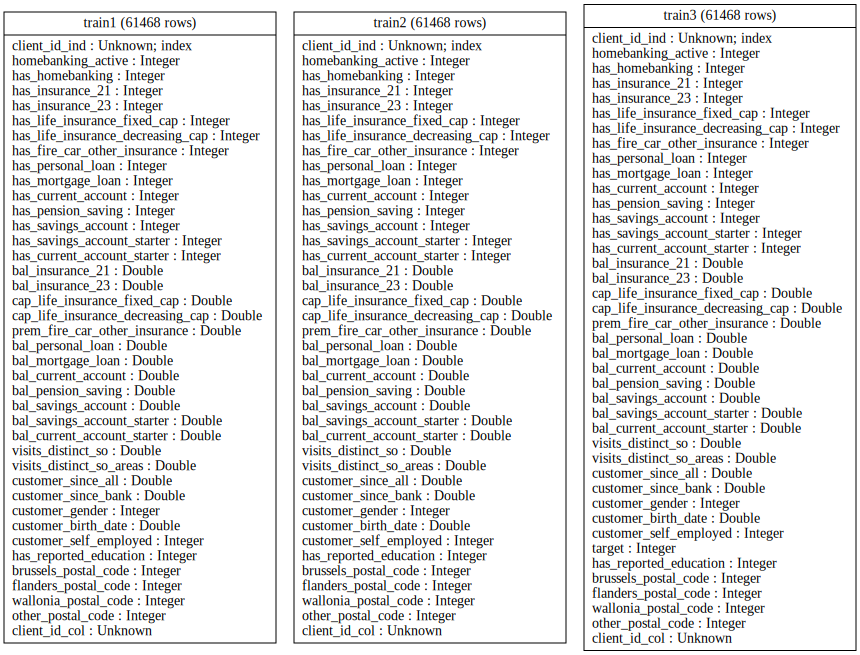

In [ ]:
import featuretools as ft
es = ft.EntitySet(id="training_data")

#When we do not initialize Woodwork, the first columns of dataframes added to the EntitySet will be taken as the index. Since featuretools is built for one-to-many
#relationships, it always matches the index of the parent dataframe to the key_column of the child. So below transformations are needed for featuretools to work
train_data1.rename(mapper={'client_id': 'client_id_ind'}, axis=1,inplace=True)
train_data1["client_id_col"] = train_data1["client_id_ind"]
train_data2.rename(mapper={'client_id': 'client_id_ind'}, axis=1,inplace=True)
train_data2["client_id_col"] = train_data2["client_id_ind"]
train_data3.rename(mapper={'client_id': 'client_id_ind'}, axis=1,inplace=True)
train_data3["client_id_col"] = train_data3["client_id_ind"]

es["train1"] = train_data1
es["train2"] = train_data2
es["train3"] = train_data3

es = es.add_relationship("train2", "client_id_ind", "train1", "client_id_col") #parent_df name, parent_key, child_df name, child_key (assumes one-to-many by default)
es = es.add_relationship("train3", "client_id_ind", "train2", "client_id_col")
es.plot()

#Extend this for time series analysis: https://featuretools.alteryx.com/en/stable/guides/time_series.html NOT SURE IF IT IS WORTH THE EFFORT FOR US